### 曲线间预测

#### 先看一下之前拟合出来的东西

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
corr_df = pd.read_csv(f"{table_dir}/corrs.csv")
display(corr_df)

,seqName,sceneId,preset,size,popt,func,target,r2,y0,y1,y2,y3,y4
0,Lecture-003a,0,faster,1080P,"(-0.16326344151660152, 15.030353642916932)",linear,log2bitrate,9.979888e-01,11.539548,11.040621,10.429761,9.874282,9.378031
1,Lecture-003a,0,faster,1080P,"(78.77031354394663, -0.6107135290783908)",power,log2bitrate,9.752646e-01,11.539548,11.040621,10.429761,9.874282,9.378031
2,Lecture-003a,0,faster,1080P,"(-0.002169759347481953, 12.155285194958516)",quadratic2,log2bitrate,9.776118e-01,11.539548,11.040621,10.429761,9.874282,9.378031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114429,Lecture-7f7e,4,slower,720P,"(232.28017811873178, -0.2671392803476199)",power,vmaf,7.191520e-01,96.924079,96.477309,95.903620,95.076089,94.081648
114430,Lecture-7f7e,4,slower,720P,"(-0.010538010925847274, 104.95940753659809)",quadratic2,vmaf,9.055661e-01,96.924079,96.477309,95.903620,95.076089,94.081648
114431,Lecture-7f7e,4,slower,720P,"(0.24649900666125613, 89.58444953035915)",exp,vmaf,9.992007e-16,96.924079,96.477309,95.903620,95.076089,94.081648


In [5]:
corr_df.func.unique()

array(['linear', 'power', 'quadratic2', 'exp'], dtype=object)

,seqName,sceneId,preset,size,popt,func,target,r2,y0,y1,y2,y3,y4,p1,p2
0,Lecture-42c3,0,faster,1080P,"(-0.11536774562912755, 12.692217471295544)",linear,log2bitrate,0.991785,10.020230,9.740601,9.435280,9.151626,8.867608,-0.115368,12.692217
1,Lecture-42c3,0,faster,360P,"(-0.1465842420551326, 11.97152426314768)",linear,log2bitrate,0.989518,8.510962,8.210758,7.866410,7.505404,7.150908,-0.146584,11.971524
2,Lecture-42c3,0,faster,540P,"(-0.15393305892668419, 12.777045031913893)",linear,log2bitrate,0.991608,9.156367,8.851174,8.488512,8.070468,7.687394,-0.153933,12.777045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Lecture-7e40,1,slower,360P,"(-0.15042731523678035, 12.53502092111007)",linear,log2bitrate,0.998930,9.284055,8.820429,8.268729,7.782031,7.366031,-0.150427,12.535021
262,Lecture-7e40,1,slower,540P,"(-0.15397433928276086, 13.342842033331811)",linear,log2bitrate,0.998647,9.946343,9.506550,8.985949,8.509841,8.096995,-0.153974,13.342842
263,Lecture-7e40,1,slower,720P,"(-0.150887316124423, 13.73464732190675)",linear,log2bitrate,0.998520,10.487577,10.022972,9.467241,8.967461,8.533527,-0.150887,13.734647


<Axes: xlabel='p1', ylabel='p2'>

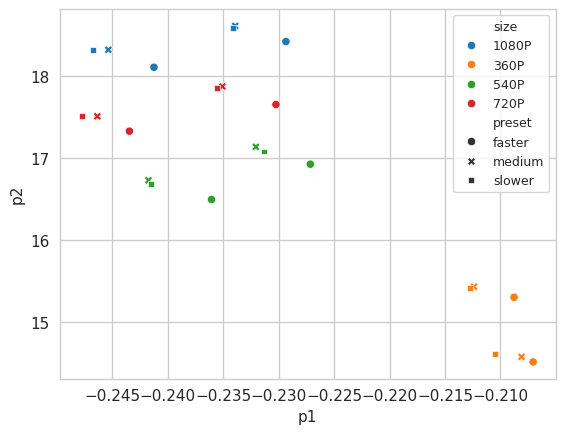

In [17]:
# 看一下预测 log2bitrate 的
data_dir = "/home/zhaoy/asset-fastCAE/dataset/vvenc"
df = pd.read_csv(f"{data_dir}/corr_linear/corr_log2bitrate_test.csv")
display(df)

sns.scatterplot(
    data=df[(df["seqName"] == "Lecture-5f3a")], 
    x="p1", y="p2", hue="size", style="preset"
)

# 发现还是同一 resolution 下，不同 preset 之间的相关性比较高

In [18]:
import os
import logging
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd
from multiprocessing import Pool

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

data_dir = f"/home/zhaoy/asset-fastCAE/dataset/vvenc"
rlt_dir  = "/home/zhaoy/asset-fastCAE/results/vvenc/tables/predCurve"
os.makedirs(rlt_dir, exist_ok=True)

In [19]:
def build_keras_regressor(input_dim, output_dim, optimizer="adam"):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim))

    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    return model

In [28]:
def _single_regression(train_df, test_df, preset_x, regressor_cls, regressor_params, metrics=None, scale=True, verbose=False):
    """
    Train and Evaluate -> ML-based curve param regression
    """
    metrics = ["p1", "p2"] if metrics is None else metrics
    pred_metrics = [f"pred_{x}" for x in metrics]

    train_df = train_df.sort_values(by=["preset", "size", "seqName", "sceneId"]).reset_index(drop=True)
    test_df = test_df.sort_values(by=["preset", "size", "seqName", "sceneId"]).reset_index(drop=True)

    train_x = train_df[train_df["preset"] == preset_x][metrics + [f"y{i}" for i in range(5)]].astype(float)
    test_x  = test_df[test_df["preset"] == preset_x][metrics + [f"y{i}" for i in range(5)]].astype(float)
    assert (train_x.empty == False) and (test_x.empty == False)

    regressor_name = regressor_cls if regressor_cls in ["Adam", "RMSProp"] else regressor_cls.__name__

    rows  = []
    pred_dfs = []
    for preset in train_df["preset"].unique():
        train_y = train_df[(train_df["preset"] == preset)][metrics].astype(float)
        test_y  = test_df[(test_df["preset"] == preset)][metrics].astype(float)

        if train_y.empty or test_y.empty:
            continue

        pred_df = test_df[(test_df["preset"] == preset)][["seqName", "sceneId"]]
        pred_df["regressor"] = regressor_name
        pred_df["input"]  = preset_x
        pred_df["preset"] = preset
        pred_df[metrics]  = test_y

        if preset == preset_x:
            pred_df[pred_metrics] = test_y
            pred_dfs.append(pred_df)
            continue

        # scaling data
        if scale:
            scaler_x = preprocessing.MinMaxScaler()
            train_x  = scaler_x.fit_transform(train_x)
            test_x   = scaler_x.fit_transform(test_x)

            scaler_y = preprocessing.MinMaxScaler()
            train_y  = scaler_y.fit_transform(train_y)
            test_y   = scaler_y.fit_transform(test_y)

        # regression
        if regressor_cls in ["Adam", "RMSProp"]:
            optimizer = Adam() if regressor_cls == "Adam" else RMSprop()
            regressor = build_keras_regressor(input_dim=len(metrics) + 5, output_dim=len(metrics), optimizer=optimizer)
            regressor.fit(train_x, train_y, **regressor_params)
        else:
            regressor = MultiOutputRegressor(regressor_cls(**regressor_params))
            regressor.fit(train_x, train_y)

        # training performance
        train_y_pred = regressor.predict(train_x)
        if scale:
            train_y_pred = scaler_y.inverse_transform(train_y_pred)
            train_y = scaler_y.inverse_transform(train_y)

        train_r2  = r2_score(train_y, train_y_pred, multioutput="raw_values")
        train_rmse = mean_squared_error(train_y, train_y_pred, squared=False) / len(train_y)
        train_evs = explained_variance_score(train_y, train_y_pred, multioutput="raw_values")

        # testing performance
        test_y_pred = regressor.predict(test_x)
        if scale:
            test_y_pred = scaler_y.inverse_transform(test_y_pred)
            test_y = scaler_y.inverse_transform(test_y)
        pred_df[pred_metrics] = test_y_pred
        pred_dfs.append(pred_df)

        test_r2 = r2_score(test_y, test_y_pred, multioutput="raw_values")
        test_rmse = mean_squared_error(test_y, test_y_pred, squared=False) / len(test_y)
        test_evs = explained_variance_score(test_y, test_y_pred, multioutput="raw_values")

        if verbose:
            print(f"preset: {preset}, input: {preset_x}, regressor: {regressor_name}, train_rmse: {train_rmse}, train_r2: {train_r2}, train_evs: {train_evs}, test_rmse: {test_rmse}, test_r2: {test_r2}, test_evs: {test_evs}")

        rows.append([preset, f"{preset_x}", regressor_name, train_rmse, train_r2, train_evs, test_rmse, test_r2, test_evs])

    rlts  = pd.DataFrame(rows, columns=["preset", "input", "regressor", "train_rmse", "train_r2", "train_evs", "test_rmse", "test_r2", "test_evs"])
    preds = pd.concat(pred_dfs, axis=0).reset_index(drop=True)

    return rlts, preds

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
regressors = {
    RandomForestRegressor: {'n_estimators': 1000, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42},
    LinearRegression: {},
    LinearSVR: {'C': 1.0, 'epsilon': 0.1, 'max_iter': 30000, 'tol': 1e-4, 'random_state': 42},
    SGDRegressor: {'loss': 'huber', 'penalty': 'l1', 'alpha': 0.001, 'learning_rate': 'optimal', 'max_iter': 30000, 'tol': 1e-4, 'random_state': 42},
    'Adam': {'epochs': 5000, 'batch_size': 128, 'verbose': False, 'validation_split':0.1, 'callbacks':[early_stopping]},
    'RMSProp': {'epochs': 5000, 'batch_size': 128, 'verbose': False,  'validation_split':0.1, 'callbacks':[early_stopping]}
}

def _multi_regression(
        target,
        func="quadratic3",
        preset_x="faster",
):
    train_df = pd.read_csv(f"{data_dir}/corr_{func}/corr_{target}_train.csv")
    test_df = pd.read_csv(f"{data_dir}/corr_{func}/corr_{target}_test.csv")

    metrics = ["p1", "p2", "p3"] if func in ["quadratic3"] else ["p1", "p2"]

    all_rlts = []
    all_preds = []
    for regressor_cls, regressor_params in regressors.items():
        try:
            rlts, preds = _single_regression(
                train_df, test_df,
                preset_x=preset_x, 
                regressor_cls=regressor_cls,
                regressor_params=regressor_params,
                metrics=metrics, 
                scale=True, 
                verbose=True
            )
        except Exception as e:
            print(f"{e} ({target}, {func}, {preset_x}, {regressor_cls})")
            continue
        
        all_rlts.append(rlts)
        all_preds.append(preds)

    rlts_df = pd.concat(all_rlts, axis=0)
    rlts_df["func"]   = func
    rlts_df["target"] = target

    preds_df = pd.concat(all_preds, axis=0)
    preds_df["func"]   = func
    preds_df["target"] = target

    os.makedirs(f"{rlt_dir}/corr_{func}", exist_ok=True)
    rlts_df.to_csv(f"{rlt_dir}/corr_{func}/rlt_{target}.csv", index=False)
    preds_df.to_csv(f"{rlt_dir}/corr_{func}/pred_{target}.csv", index=False)

    return rlts_df, preds_df


def process_task(params):
    target, func, preset_x = params
    rlts_df, preds_df = _multi_regression(target=target, func=func, preset_x=preset_x)
    return rlts_df, preds_df

In [ ]:
tasks = []
for target in ["bitrate", "log2bitrate", "psnr", "log2psnr", "ssim", "log2ssim", "vmaf", "log2vmaf"]:
    for func in ["linear", "power", "quadratic2"]:
        for preset_x in ["faster", "medium", "slower"]:
            tasks.append((target, func, preset_x))

with Pool(processes = os.cpu_count()) as pool:
    results = pool.map(process_task, tasks)

all_rlts  = [rlt[0] for rlt in results]
all_preds = [rlt[1] for rlt in results]

all_rlts_df = pd.concat(all_rlts, axis=0).reset_index(drop=True)
all_preds_df = pd.concat(all_preds, axis=0).reset_index(drop=True)

all_rlts_df.to_csv(f"{rlt_dir}/all_rlts.csv", index=False)
all_preds_df.to_csv(f"{rlt_dir}/all_preds.csv", index=False)

In [32]:
all_rlts_df  = pd.read_csv(f"{rlt_dir}/all_rlts.csv")
all_preds_df = pd.read_csv(f"{rlt_dir}/all_preds.csv")

display(all_rlts_df)
display(all_preds_df)

,preset,input,regressor,train_rmse,train_r2,train_evs,test_rmse,test_r2,test_evs,func,target
0,medium,faster,RandomForestRegressor,0.022349,[0.99924234 0.99928479],[0.99924244 0.99928503],1.204733,[0.995651 0.99321329],[0.99616087 0.99495926],linear,bitrate
1,slower,faster,RandomForestRegressor,0.023354,[0.99921784 0.99920989],[0.99921789 0.99921007],1.074181,[0.99502899 0.99432241],[0.99508493 0.99496096],linear,bitrate
2,medium,faster,LinearRegression,0.036871,[0.99809781 0.99804983],[0.99809781 0.99804983],6.299066,[0.84016749 0.81548139],[0.84166681 0.82309188],linear,bitrate
...,...,...,...,...,...,...,...,...,...,...,...
861,medium,slower,Adam,0.000016,[0.31189083 0.40477844],[0.83078477 0.40964492],0.000899,[ 0.61865729 -0.73515185],[0.6542037 0.41644761],quadratic2,log2vmaf
862,faster,slower,RMSProp,0.000009,[0.9405283 0.87148854],[0.94066218 0.88412206],0.000520,[0.79746179 0.63437317],[0.90134775 0.85367243],quadratic2,log2vmaf
863,medium,slower,RMSProp,0.000006,[0.97033663 0.93046828],[0.97176853 0.9316879 ],0.000406,[0.8859868 0.64694004],[0.93928953 0.88925675],quadratic2,log2vmaf


,seqName,sceneId,regressor,input,preset,p1,p2,pred_p1,pred_p2,func,target
0,Lecture-42c3,0,RandomForestRegressor,faster,faster,-30.571893,1576.732812,-30.571893,1576.732812,linear,bitrate
1,Lecture-42c3,1,RandomForestRegressor,faster,faster,-39.516805,2042.256954,-39.516805,2042.256954,linear,bitrate
2,Lecture-42c3,2,RandomForestRegressor,faster,faster,-51.205407,2652.773792,-51.205407,2652.773792,linear,bitrate
...,...,...,...,...,...,...,...,...,...,...,...
114045,Lecture-6d29,11,RMSProp,slower,slower,-0.000330,6.852200,-0.000330,6.852200,quadratic2,log2vmaf
114046,Lecture-7e40,0,RMSProp,slower,slower,-0.000122,6.707508,-0.000122,6.707508,quadratic2,log2vmaf
114047,Lecture-7e40,1,RMSProp,slower,slower,-0.000175,6.748989,-0.000175,6.748989,quadratic2,log2vmaf
